## Predicting NYC subway usage

This notebook explores a NYC subway dataset, and tries to forecast the number of people that uses the subway.

In [1]:
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import r2_score,  mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

First, we'll explore the dataset, using the 2010 file as reference. As we can see below, the info is grouped by, among others, the stations. We'll focus on the biggest station of NY, the Times Square - 42nd Street.

In [2]:
df_2010 = pd.read_csv('data/2010.csv')

Brief description of the fields:
- CA = Control Area (A002) 
- UNIT = Remote Unit for a station (R051) 
- SCP = Subunit Channel Position represents an specific address for a device (02-00-00) 
- STATION = Represents the station name the device is located at 
- LINENAME = Represents all train lines that can be boarded at this station Normally lines are represented by one character. 
- DATE = Represents the date (MM-DD-YY) 
- TIME = Represents the time (hhmmss) for a scheduled audit event 
- DECS = Represent the REGULAR scheduled audit event (Normally occurs every 4 hours) 1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 2. Additionally, there may be a RECOVR AUD entry. This refers to a missed audit that was recovered. 
- ENTRIES = The comulative entry register value for a device 
- EXITS = The cumulative exit register value for a device

In [3]:
df_2010.set_index('time', inplace=True)
df_2010.head()

,ca,unit,scp,station,linename,division,desc,entries,exits
time,,,,,,,,,
2010-04-17 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2704717.0,928793.0
2010-04-17 04:00:00,A002,R051,02-00-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2697632.0,566683.0
2010-04-17 04:00:00,A002,R051,02-03-00,LEXINGTON AVE,456NQR,BMT,REGULAR,1127722.0,3943492.0
2010-04-17 04:00:00,A002,R051,02-03-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2425570.0,3733289.0
2010-04-17 04:00:00,A002,R051,02-03-02,LEXINGTON AVE,456NQR,BMT,REGULAR,2214633.0,3021589.0


There are 383 stations in the dataset

In [4]:
len(df_2010.station.unique())

383

In [5]:
df_2010.query('station == "42 ST-TIMES SQ"', inplace=True)
df_2010.head()

,ca,unit,scp,station,linename,division,desc,entries,exits
time,,,,,,,,,
2010-04-17 04:00:00,A021,R032,01-00-00,42 ST-TIMES SQ,1237ACENQRS,BMT,REGULAR,19250.0,18644.0
2010-04-17 04:00:00,A021,R032,01-00-02,42 ST-TIMES SQ,1237ACENQRS,BMT,REGULAR,689412.0,614614.0
2010-04-17 04:00:00,A021,R032,01-00-03,42 ST-TIMES SQ,1237ACENQRS,BMT,REGULAR,7146.0,2702.0
2010-04-17 04:00:00,A021,R032,01-00-04,42 ST-TIMES SQ,1237ACENQRS,BMT,REGULAR,2679472.0,4261965.0
2010-04-17 04:00:00,A021,R032,01-00-05,42 ST-TIMES SQ,1237ACENQRS,BMT,REGULAR,553366.0,1786666.0


Now, we need to focus in one turnstile (SCP) and one division in order to have a timeseries without duplicated timestamps.

In [6]:
df_2010.division.unique(), df_2010.scp.unique()

(array(['BMT', 'IRT'], dtype=object),
 array(['01-00-00', '01-00-02', '01-00-03', '01-00-04', '01-00-05',
        '01-00-06', '01-00-07', '02-00-00', '02-00-01', '02-00-02',
        '02-00-03', '02-03-00', '02-03-01', '02-03-02', '02-03-03',
        '00-00-00', '00-00-01', '00-00-02', '00-00-03', '00-00-04',
        '00-06-00', '00-06-01', '00-06-02', '04-00-00', '04-00-01',
        '04-00-02', '04-00-03', '04-00-04', '04-00-05', '04-00-06',
        '04-05-00', '04-05-01', '01-00-01', '01-03-00', '01-03-01',
        '01-03-02', '01-03-03', '01-06-00', '01-06-01', '00-00-05',
        '00-00-06', '00-00-07', '00-00-08'], dtype=object))

In [7]:
df_2010.query('station == "42 ST-TIMES SQ" and scp == "01-00-00" and division == "BMT"', inplace=True)
df_2010[df_2010.duplicated(keep=False)]

,ca,unit,scp,station,linename,division,desc,entries,exits
time,,,,,,,,,
2010-05-28 17:15:57,A021,R032,01-00-00,42 ST-TIMES SQ,1237ACENQRS,BMT,DOOR,126230.0,133418.0
2010-05-28 17:43:20,A021,R032,01-00-00,42 ST-TIMES SQ,1237ACENQRS,BMT,DOOR,126230.0,133418.0
2010-09-17 11:44:53,A021,R032,01-00-00,42 ST-TIMES SQ,1237ACENQRS,BMT,DOOR,395852.0,445275.0
2010-09-17 11:52:27,A021,R032,01-00-00,42 ST-TIMES SQ,1237ACENQRS,BMT,DOOR,395852.0,445275.0
2010-10-08 08:00:00,A021,R032,01-00-00,42 ST-TIMES SQ,1237ACENQRS,BMT,REGULAR,448410.0,505373.0
2010-10-08 08:00:00,A021,R032,01-00-00,42 ST-TIMES SQ,1237ACENQRS,BMT,REGULAR,448410.0,505373.0
2010-10-18 14:38:39,A021,R032,01-00-00,42 ST-TIMES SQ,1237ACENQRS,BMT,DOOR,471514.0,534807.0
2010-10-18 14:46:47,A021,R032,01-00-00,42 ST-TIMES SQ,1237ACENQRS,BMT,DOOR,471514.0,534807.0
2010-10-29 17:09:16,A021,R032,01-00-00,42 ST-TIMES SQ,1237ACENQRS,BMT,DOOR,502996.0,570830.0


Even after filtering by scp and division, there were a few duplicates left. We'll remove them and continue

In [8]:
df_2010 = df_2010[~df_2010.index.duplicated(keep='first')]

In [9]:
df_2010.ca.unique(), df_2010.unit.unique(), df_2010.scp.unique(), df_2010.linename.unique(), df_2010.division.unique(), df_2010.desc.unique()

(array(['A021'], dtype=object),
 array(['R032'], dtype=object),
 array(['01-00-00'], dtype=object),
 array(['1237ACENQRS'], dtype=object),
 array(['BMT'], dtype=object),
 array(['REGULAR', 'AUD', 'DOOR', 'OPEN', 'RECOVR'], dtype=object))

Now there are not any duplicated values. The only column that can be used as features, besides the entries and exits, is the "desc" column". The other columns are constant. 

As we can see below, the Entries' data looks like a linear function.

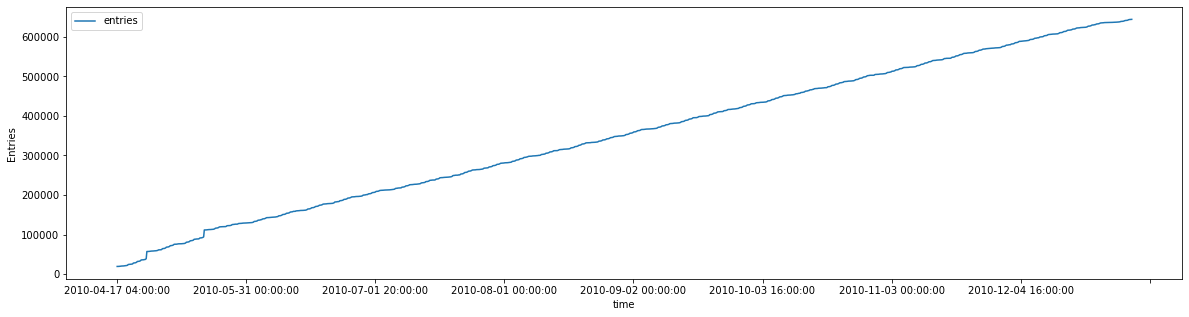

In [10]:
df_2010.plot(y="entries", figsize=(20,5), ylabel='Entries')

Now, we'll read data from 2011 to 2015 (for memory reasons), using the same criteria (filtering by station, scp, and division).

In [11]:
years = ['2011', '2012', '2013', '2014', '2015']

for year in years:
    df = pd.read_csv('data/'+year+'.csv')
    df.query('station == "42 ST-TIMES SQ" and scp == "01-00-00" and division == "BMT"', inplace=True)
    df = df.loc[~df.index.duplicated(keep='first')]
    df = df.set_index('time')
    df_2010 = pd.concat([df_2010, df])
df = df_2010
df

,ca,unit,scp,station,linename,division,desc,entries,exits
time,,,,,,,,,
2010-04-17 04:00:00,A021,R032,01-00-00,42 ST-TIMES SQ,1237ACENQRS,BMT,REGULAR,19250.0,18644.0
2010-04-17 08:00:00,A021,R032,01-00-00,42 ST-TIMES SQ,1237ACENQRS,BMT,REGULAR,19267.0,18668.0
2010-04-17 12:00:00,A021,R032,01-00-00,42 ST-TIMES SQ,1237ACENQRS,BMT,REGULAR,19287.0,18726.0
2010-04-17 16:00:00,A021,R032,01-00-00,42 ST-TIMES SQ,1237ACENQRS,BMT,REGULAR,19424.0,19129.0
2010-04-17 20:00:00,A021,R032,01-00-00,42 ST-TIMES SQ,1237ACENQRS,BMT,REGULAR,19674.0,19546.0
...,...,...,...,...,...,...,...,...,...
2015-12-25 12:00:00,A021,R032,01-00-00,42 ST-TIMES SQ,ACENQRS1237,BMT,REGULAR,5341668.0,6263145.0
2015-12-25 16:00:00,A021,R032,01-00-00,42 ST-TIMES SQ,ACENQRS1237,BMT,REGULAR,5341719.0,6263313.0
2015-12-25 20:00:00,A021,R032,01-00-00,42 ST-TIMES SQ,ACENQRS1237,BMT,REGULAR,5341865.0,6263713.0


In [12]:
df.entries.describe()

count    1.353400e+04
mean     2.630961e+06
std      1.505622e+06
min      9.000000e+00
25%      1.324312e+06
50%      2.596946e+06
75%      3.918064e+06
max      5.342213e+06
Name: entries, dtype: float64

To predict the entries, we need to enrich our data with some features. We'll use mainly time features and the entries and exits from the previous timestamp. We remove the first register because of the time shift.

In [13]:
df.index = pd.to_datetime(df.index)
df['date'] = df.index
df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['dayofmonth'] = df['date'].dt.day
df['desc_code'] = pd.Categorical(df.desc)
df['desc_code'] =  df['desc_code'].cat.codes
df['prev_entries'] = df['entries'].shift(1)
df['prev_exits'] = df['exits'].shift(1)
X = df[['prev_entries', 'prev_exits','desc_code', 
    'hour','dayofweek','month',
    'dayofmonth']][1:]

In [14]:
y = df[['entries']][1:]

In [15]:
X,y

(                     prev_entries  prev_exits  desc_code  hour  dayofweek  \
 time                                                                        
 2010-04-17 08:00:00       19250.0     18644.0          9     8          5   
 2010-04-17 12:00:00       19267.0     18668.0          9    12          5   
 2010-04-17 16:00:00       19287.0     18726.0          9    16          5   
 2010-04-17 20:00:00       19424.0     19129.0          9    20          5   
 2010-04-18 00:00:00       19674.0     19546.0          9     0          6   
 ...                           ...         ...        ...   ...        ...   
 2015-12-25 12:00:00     5341644.0   6263114.0          9    12          4   
 2015-12-25 16:00:00     5341668.0   6263145.0          9    16          4   
 2015-12-25 20:00:00     5341719.0   6263313.0          9    20          4   
 2015-12-26 00:00:00     5341865.0   6263713.0          9     0          5   
 2015-12-26 04:00:00     5342048.0   6264318.0          9     4 

### First strategy - Linear Regressor
Linear regression is a simple strategy, but, by looking the data, it seems a good starting point. We'll split the dataset in 80/20 and use cross-validation.
To evaluate the model, we'll use [R2 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) and [MAPE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html).

In [16]:
estimator = LinearRegression()

In [17]:
split_fraction = 0.80
train_split = int(split_fraction * int(X.shape[0]))

In [18]:
x_train = X[:train_split]
y_train = y[:train_split]

x_val = X[train_split:]
y_val = y[train_split:]

In [19]:
y_pred = cross_val_predict(estimator, x_val, y_val, n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


r2 score:  0.9998934784825358
MAPE score:  0.0004109045033813943


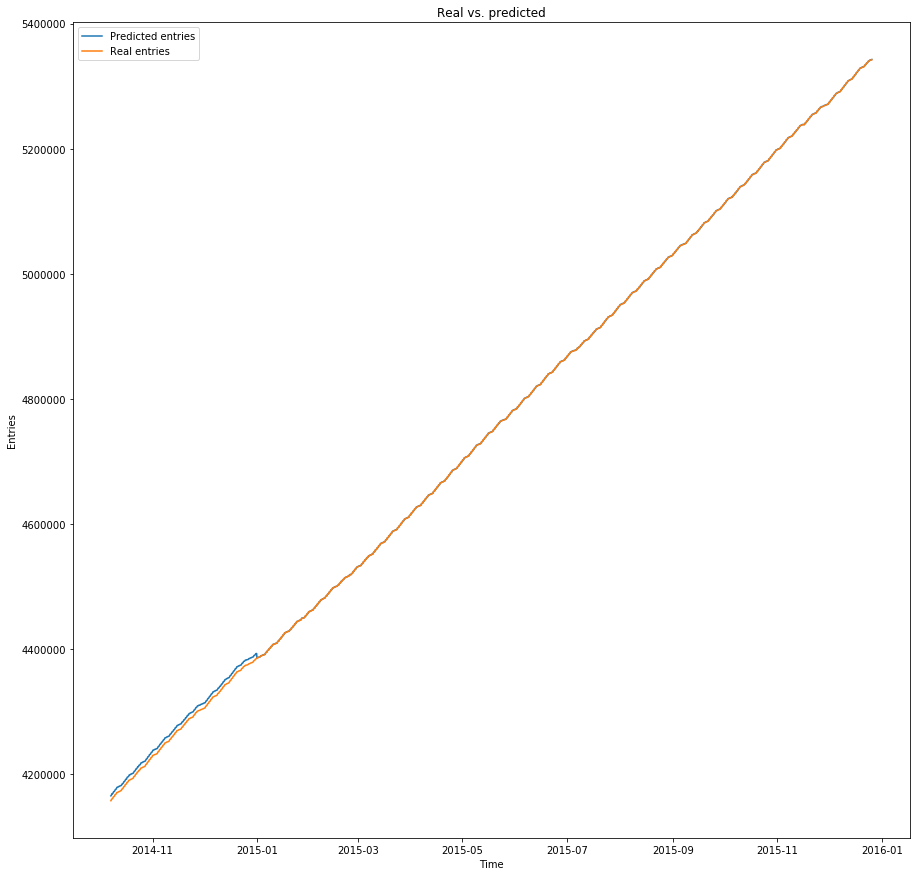

In [20]:
def plot_results(x, y_val, y_pred):
    plt.figure(figsize=(15,15))
    ax1 = plt.plot(x, y_pred, label='Predicted entries')
    ax2 = plt.plot(x, y_val, label='Real entries')
    plt.legend(loc="upper left")
    plt.title('Real vs. predicted')
    plt.xlabel('Time')
    plt.ylabel('Entries')
    print("r2 score: ", r2_score(y_val, y_pred))
    print("MAPE score: ", mean_absolute_percentage_error(y_val, y_pred))
    plt.show()

plot_results(y_val.index.values, y_val.values, y_pred)

The results were very good. Let's see how a more sofisticated strategy behaves on the same problem.

### Second strategy: LSTM
LSTMs are a very suitable architecture to time series problems. We'll use 12 past registers to predict 1 register from the future. The split ratio and the metrics are the same as the Linear Regression.

In [21]:
step = 1
past = 12
future = 1
learning_rate = 0.001
batch_size = 64
epochs = 5

In [22]:
features =  X.values

In [23]:
x_train = features[:train_split]
x_val = features[train_split:]

y_train = y.values[:train_split]
y_val = y.values[train_split:]
y_val_index = y.index.values[train_split:]

In [24]:
start = past + future
end = start + train_split

sequence_length = past

In [25]:
dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [26]:
x_end = len(y_val) - past - future

label_start = train_split + past + future

dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)


Input shape: (64, 12, 7)
Target shape: (64, 1)


In [27]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(128,  activation='relu')(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.MeanSquaredLogarithmicError())
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 7)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               69632     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [28]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/5
169/169 [==============================] - 12s 13ms/step - loss: 16.5372 - val_loss: 0.0437

Epoch 00001: val_loss improved from inf to 0.04373, saving model to model_checkpoint.h5
Epoch 2/5
169/169 [==============================] - 1s 8ms/step - loss: 0.0431 - val_loss: 0.0284

Epoch 00002: val_loss improved from 0.04373 to 0.02843, saving model to model_checkpoint.h5
Epoch 3/5
169/169 [==============================] - 1s 9ms/step - loss: 0.0131 - val_loss: 3.5392e-05

Epoch 00003: val_loss improved from 0.02843 to 0.00004, saving model to model_checkpoint.h5
Epoch 4/5
169/169 [==============================] - 1s 9ms/step - loss: 0.0071 - val_loss: 2.8654e-05

Epoch 00004: val_loss improved from 0.00004 to 0.00003, saving model to model_checkpoint.h5
Epoch 5/5
169/169 [==============================] - 1s 8ms/step - loss: 0.0112 - val_loss: 7.3487e-06

Epoch 00005: val_loss improved from 0.00003 to 0.00001, saving model to model_checkpoint.h5


loss=tf.keras.losses.MeanAbsolutePercentageError()
loss(y.values, np.array(model.predict(X))).numpy()

r2 score:  0.9987161860613368
MAPE score:  0.0023141394109477136


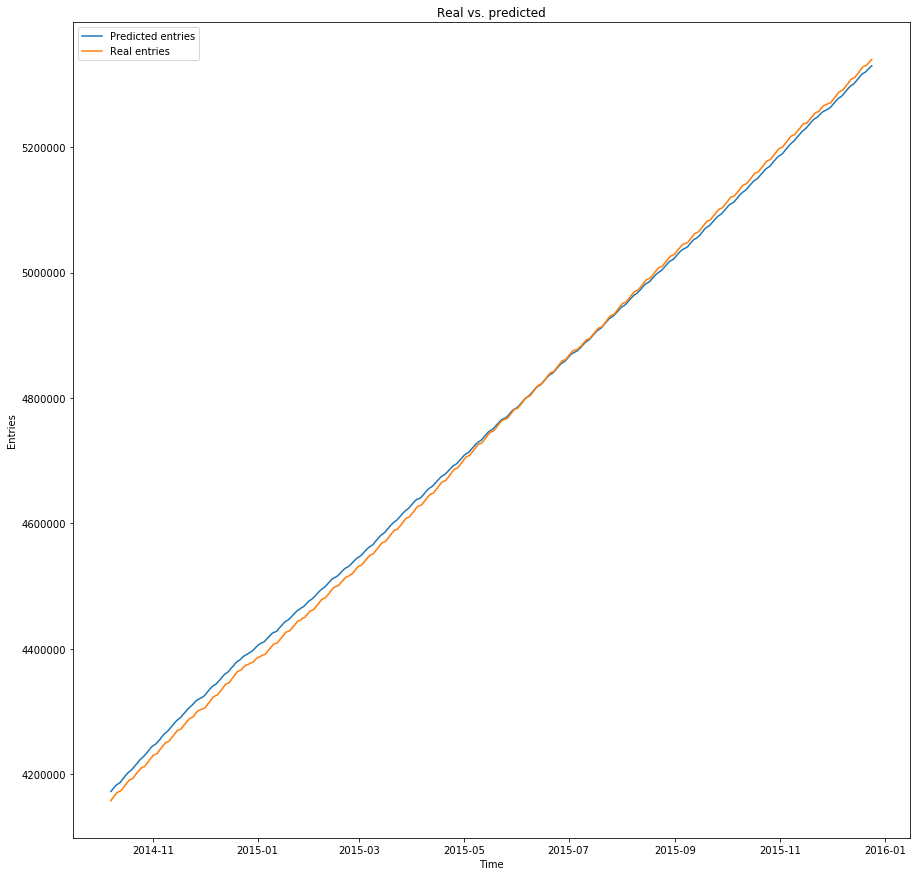

In [29]:
y_pred = model.predict(dataset_val)
plot_results(y_val_index[:len(y_pred)], y_val[:len(y_pred)], y_pred)

The resuts area little bit worse than the Linear regression. Sometimes a simple strategy works better than a more sofisticated one.